In [ ]:
# Import packages
import plotly.express as px
import pandas as pd



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 20-25 Sales .csv to 20-25 Sales .csv


In [ ]:
# Read in the data
data = pd.read_csv(r"20-25 Sales .csv")
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-4-d40c5de85a69>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
#data = data.drop(columns='Cat No')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    55 non-null     datetime64[ns]
 1   Sales   55 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1012.0 bytes


In [ ]:
#data.rename(columns={'ds': 'Date', 'y': 'Sales'}, inplace=True)

In [ ]:
#Find rows with 0's
rows_with_zeros = data[(data == 0).any(axis=1)]
rows_with_zeros

,Date,Sales
0,2020-07-20,0


In [ ]:
data = data.drop(0, axis=0)


In [ ]:
data.head()

,Date,Sales
1,2020-08-01,11
2,2020-09-01,31
3,2020-10-01,46
4,2020-11-01,31
5,2020-12-01,38


In [ ]:
#Plot Data
def plot_sales_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the sales data."""

    fig = px.line(df, x='Date', y=y, labels='Date')
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Company Sales',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the Sales data
plot_sales_volumes(df=data, y='Sales')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

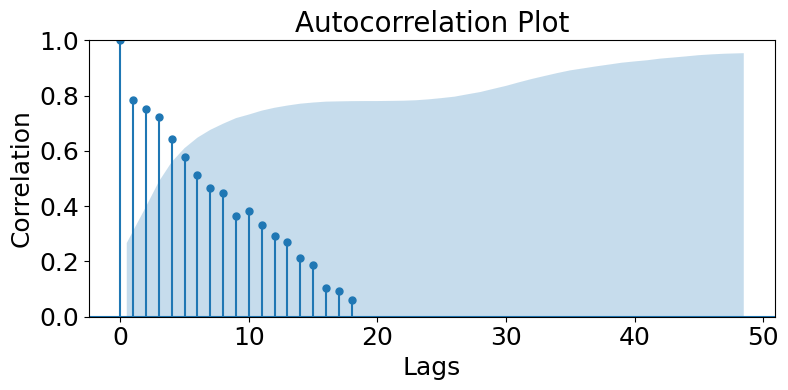

In [ ]:
# Plot autocorrelation
plt.rc("figure", figsize=(8,4))
plot_acf(data['Sales'], lags=48)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

Seasonality of 10 may be a good fit for this model with our data.

In [82]:
# Import packages
from scipy.stats import boxcox

# Make the data stationary
data['Sales_Boxcox'], lam = boxcox(data['Sales'])
data["Sales_diff"] = data["Sales_Boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary Sales data
plot_sales_volumes(df=data, y='Sales_diff')

ADF test to make sure data is stationary to be used in ARIMA model

In [81]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
  test_results = adfuller(series)
  print('ADF statistic: ', test_results[0])
  print('P-value: ', test_results[1])
  print('Critical Values: ')
  for thres, adf_stat in test_results[4].items():
    print('\t%s: %.2f' % (thres, adf_stat))
adf_test(data["Sales_diff"][1:])



ADF statistic:  -8.080089878321617
P-value:  1.4693518472058474e-12
Critical Values: 
	1%: -3.57
	5%: -2.92
	10%: -2.60


Data is very stationary -8.08 is way lower that than the 1% value and the p-value is <.05 so the p-value rejects the null hypothesis that the data is non-stationary.


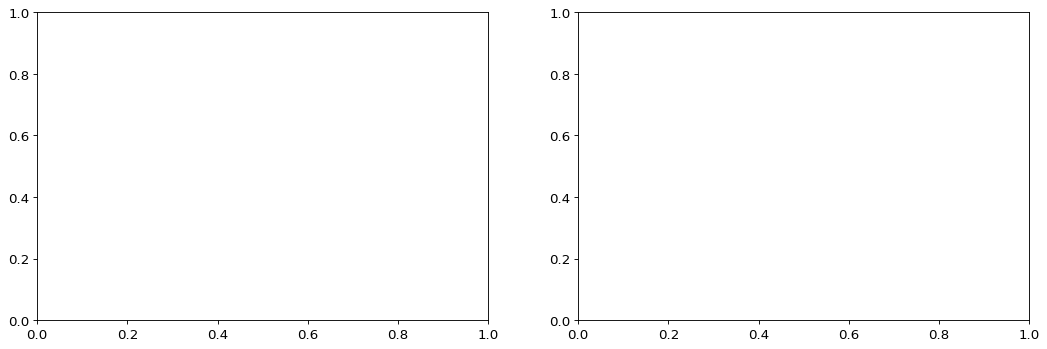

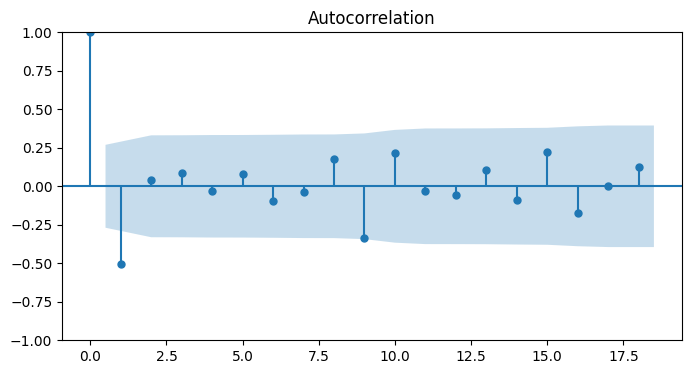

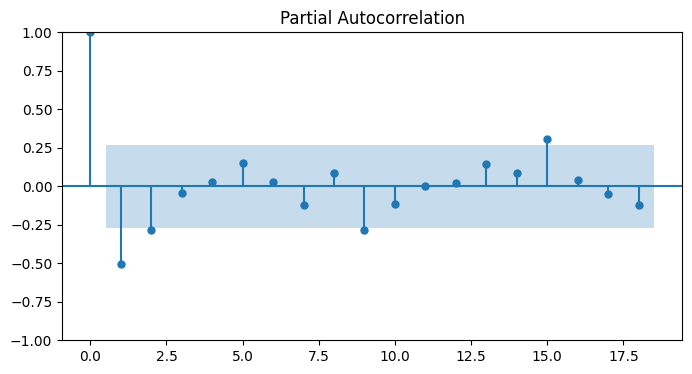

In [ ]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(data['Sales_diff'])
plot_pacf(data['Sales_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [72]:
# Import packages
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build ARIMA model
model = ARIMA(train['Sales_Boxcox'], order=(1, 1,1),
              seasonal_order=(1, 1, 1,10)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespac

In [73]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Sales'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Sales'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Sales')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'SARIMA')

In [64]:
forecasts

,predicted_mean
43,142.441558
44,100.375621
45,116.301311
46,112.181153
47,123.643705
48,112.330868
49,90.433016
50,124.895440
51,106.035369
52,106.543300
